## Device check

In [1]:
!nvidia-smi

Wed Oct 25 01:04:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| N/A   30C    P0    38W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Packages

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [108]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

from matplotlib import pyplot

import numpy as np

import logging
logging.basicConfig(level="INFO")
import os

import pandas as pd
from pprint import pprint

import sys
sys.path.append("../src")

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary

import lightning.pytorch as pl

In [46]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
import config
from dataloader import BEDataset, BEDataModule
import token_learner
from transformer import PositionalEncoder,TransformerDecoder, generate_masks

from film_layers import FiLMBlockV2, FiLMEncoder, ResBlockDWConv
from rt1 import RT1Encoder
from utils.data_utils import History
from utils.model_utils import TextEncoder, ImageFeatureExtractor


## Load data summary

In [6]:
csv = pd.read_csv(os.path.join(config.DATASET_PATH, "train.csv"))

csv.head()

,sample_ID,in_state,goal_state,action_description,motor_cmd,len_action_desc,len_motor_cmd,version
0,7294,0,10,put the fork to the right of buttermilk,:FORK GREEN POSE-9 :BUTTERMILK GREEN POSE-2 :F...,8,11,v2
1,405,0,8,move the bottle backwards,:BOTTLE RED POSE-2 :BOTTLE #'*backward-transf...,4,8,v1
2,4235,0,10,put the bottle to the left of breakfast-cereal,:BOTTLE RED POSE-7 :BREAKFAST-CEREAL BLUE POSE...,8,11,v2
3,6990,0,10,put the milk in front of bottle,:MILK BLUE POSE-8 :BOTTLE RED POSE-4 :MILK #'...,7,11,v2
4,7096,0,10,put the cup in front of glasses,:CUP GREEN POSE-6 :GLASSES RED POSE-2 :CUP #'...,7,11,v2


In [7]:
# building data object
ds = BEDataset(
    df=csv    
)

len(ds)

4876

In [8]:
# fetching example
rand_idx = np.random.randint(low=0, high=len(ds))
ex = ds[rand_idx]

print("Dataset size: ", len(ds))
print("="*100)
print("ID\t: ", ex["sample_id"])
print(">> InState\t: ", ex["in_state"].shape)
print(">> Desc\t:")
pprint(ex["action_desc"])
print(">> Cmd\t:")
pprint(ex["motor_cmd"])
print("="*100)

Dataset size:  4876
ID	:  9401
>> InState	:  torch.Size([3, 224, 224])
>> Desc	:
{'ids': tensor([  101,  2404,  1996,  5442,  2000,  1996,  2157,  1997, 12256, 17130,
         2378,   102,     0,     0,     0,     0]),
 'length': 8,
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]),
 'raw': 'put the knife to the right of mondamin',
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
>> Cmd	:
{'ids': tensor([ 0, 17, 41, 30, 18, 41, 36, 17, 48, 18,  2,  2,  2,  2,  2,  2]),
 'length': 11,
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]),
 'raw': ':KNIFE GREEN POSE-10 :MONDAMIN GREEN POSE-3 :KNIFE  '
        "#'*rightward-transformation*  :MONDAMIN"}


## Data Module

In [9]:
dm = BEDataModule()
dm.setup()

Total # examples: 4876


INFO:root:Training on 3610 samples.
INFO:root:Validating on 1266 samples.


In [10]:
# print("="*100)
# logging.info("\n>> train data loader")
# print(f"# train batches\t: {len(dm.train_dataloader())}")
# for data in dm.train_dataloader():
#     # pprint(data)
#     sample_id, in_state, ad, cmd = data["sample_id"], data["in_state"], data["action_desc"], data["motor_cmd"]
#     print("In \t\t\t: ", in_state.shape)
#     print("Action desc \t\t: ", ad["ids"].shape)
#     print("Action desc (len) \t: ", ad["length"].shape)
#     print("CMD \t\t\t: ", cmd["ids"].shape)
#     print("CMD(len) \t\t: ", cmd["length"].shape)
#     break

# print("\nIDs & decided tokens")
# for data in dm.train_dataloader():
#     print(data["action_desc"]["ids"][0].tolist())
#     print(dm.train_ds._decode_inputs(data["action_desc"]["ids"][0].tolist()))
#     print()
#     print(data["motor_cmd"]["ids"][0].tolist())
#     print(dm.train_ds._decode_outputs(data["motor_cmd"]["ids"][0].tolist()))

#     break
    
# print("="*100)

## Fetch batch

In [147]:
%%time
sample = next(iter(dm.train_dataloader()))
sample["in_state"].shape

CPU times: user 11.5 ms, sys: 167 ms, total: 179 ms
Wall time: 1.55 s


torch.Size([8, 3, 224, 224])

### Utils

In [150]:
%%time 

history = History(imgs=sample["in_state"])

history.carousel.shape

CPU times: user 96.7 ms, sys: 3.87 ms, total: 101 ms
Wall time: 100 ms


torch.Size([8, 3, 6, 224, 224])

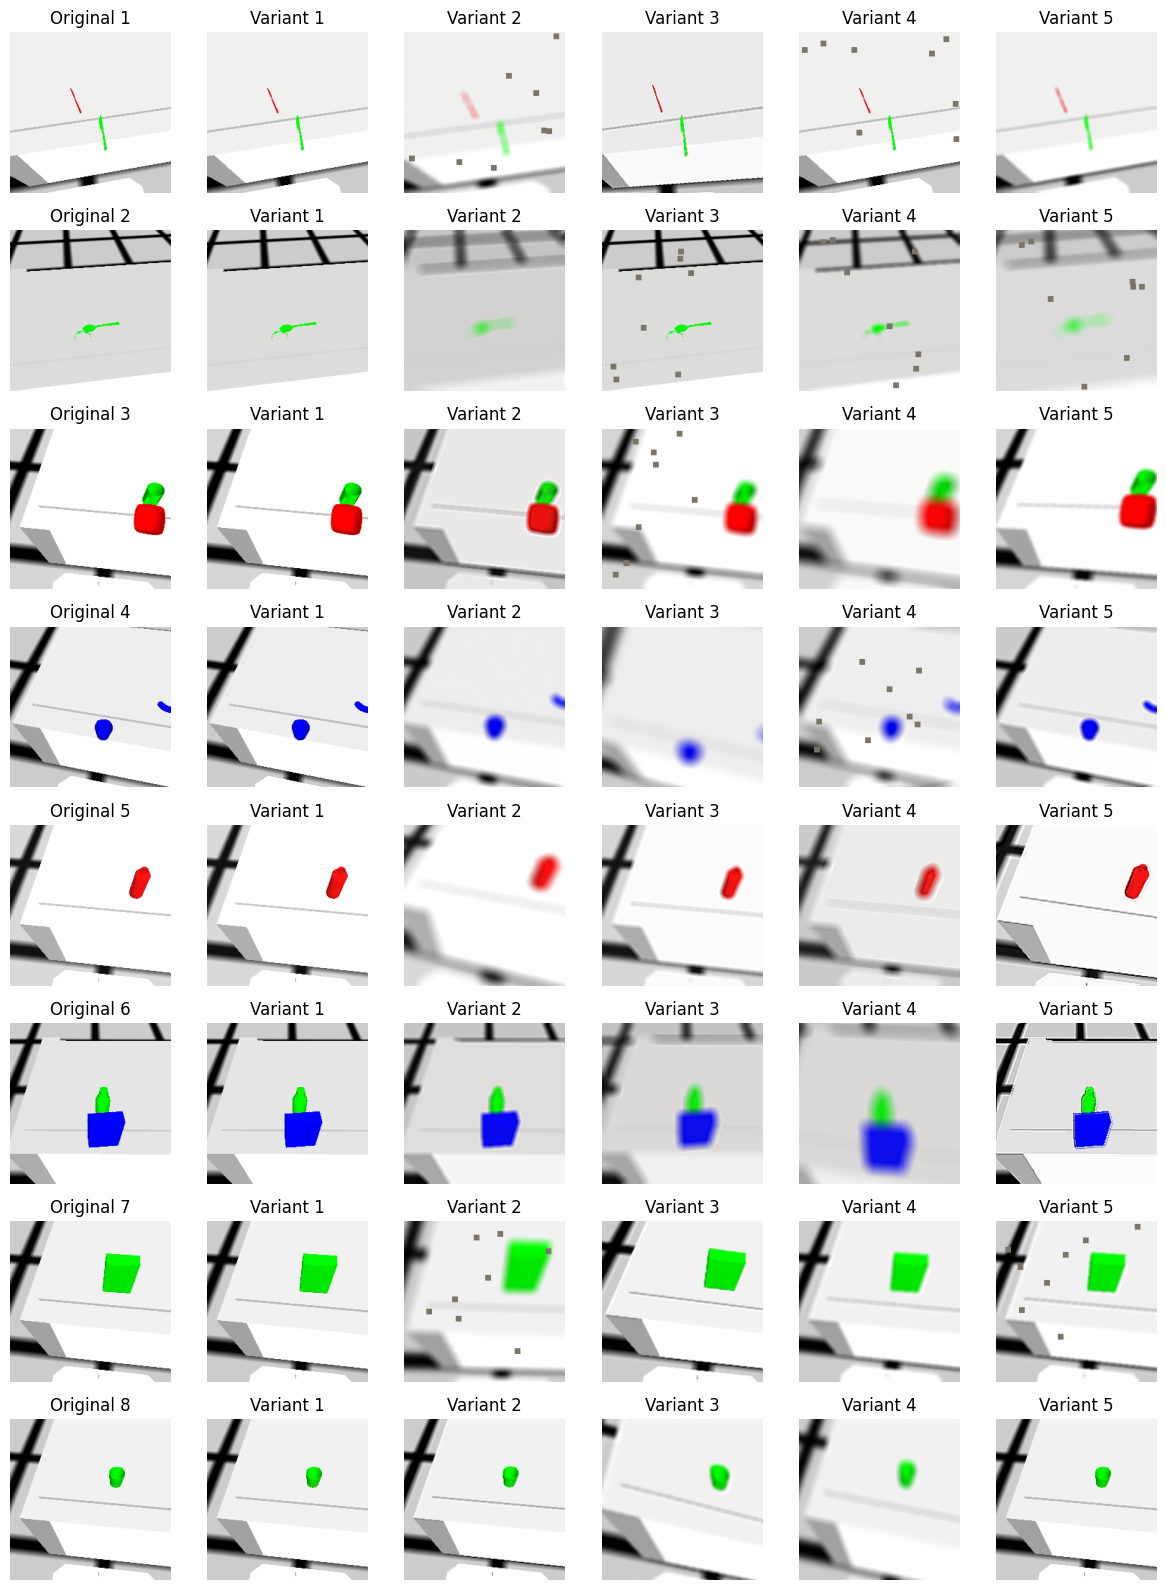

In [151]:
history.display_history()

## Model Design

<!-- ![RT1 model architecture](../../imgs/rt1+.png) -->
<center>
    <img src="../imgs/rt1+.png" alt="RT1 model architecture" width="300" height="400">

<center>

### Encoder

#### Test Text Encoder

In [12]:
# te = TextEncoder(freeze=True).cuda()
# summary(model=te, col_names=["num_params", "trainable"])

In [13]:
# emb = te(
#     inp_ids=sample["action_desc"]["ids"].cuda(),
#     mask=sample["action_desc"]["mask"].cuda(),
#     tok_type_ids=sample["action_desc"]["token_type_ids"].cuda()
# )

# emb.shape

#### Test Img Feature Extractor

In [14]:
# fe = ImageFeatureExtractor(pretrained=True, arch="resnet34").cuda()

# summary(fe, col_names=["num_params", "trainable"])

In [15]:
# img_ftrs = fe(sample["in_state"].cuda())

# img_ftrs.shape

#### Test FiLM Block

In [16]:
# film_block = FiLMBlockV2().cuda()
# print(film_block)
# summary(model=film_block)

In [17]:
# text_cond_ftrs = film_block(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs.shape

#### Test Residual FiLM Block

In [18]:
# dw_res = ResBlockDWConv(512, 512).cuda()
# summary(model=dw_res)

In [19]:
# text_cond_ftrs_res = dw_res(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs_res.shape

#### Test FiLM Encoder

In [20]:
# film_encoder = FiLMEncoder(
#     arch="resnet34",
#     n_res_blocks=6,
# ).cuda()

# # print(film_encoder)
# summary(model=film_encoder)

In [21]:
# %%time

# out = film_encoder(
#     x= sample["in_state"].cuda(),
#     conditioning= emb
# )

# out.shape

#### Token Learner

In [22]:
# N, C, H_W = out.shape
# N, C, H_W

In [23]:
# tokL_v11 = token_learner.TokenLearnerModuleV11(feature_shape=(N, H_W, C)).cuda()
# print(tokL_v11)
# summary(model=tokL_v11)

In [24]:
# learned_tokens = tokL_v11(out.view(N, H_W, C))
# learned_tokens.shape

#### RT-1 Encoder

In [154]:
tokenized_inputs = torch.empty((B, config.NUM_HISTORY+1, config.D_MODEL, config.NUM_LEARNED_TOKENS))
tokenized_inputs.shape

torch.Size([8, 6, 512, 8])

In [155]:
tokenized_inputs.view(B, -1, config.D_MODEL).shape

torch.Size([8, 48, 512])

In [156]:
history.carousel.shape

torch.Size([8, 3, 6, 224, 224])

In [ ]:
history.carousel.[0, :, ]

In [182]:
encoder = RT1Encoder(cnn_bacnbone="resnet34").to(config.DEVICE)
summary(model=encoder, col_names=["num_params", "trainable"])

Layer (type:depth-idx)                                       Param #                   Trainable
RT1Encoder                                                   --                        Partial
├─TextEncoder: 1-1                                           --                        False
│    └─BertModel: 2-1                                        --                        False
│    │    └─BertEmbeddings: 3-1                              (15,891,456)              False
│    │    └─BertEncoder: 3-2                                 (12,609,536)              False
│    │    └─BertPooler: 3-3                                  (262,656)                 False
│    └─Dropout: 2-2                                          --                        --
├─FiLMEncoder: 1-2                                           --                        Partial
│    └─ImageFeatureExtractor: 2-3                            --                        Partial
│    │    └─ResNet: 3-4                                      21

In [183]:
%%time 

src_enc, tokens = encoder._encode(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

src_enc.shape, tokens.shape

CPU times: user 17.2 ms, sys: 9.84 ms, total: 27 ms
Wall time: 25.9 ms


(torch.Size([8, 512]), torch.Size([8, 512, 8]))

In [ ]:
%%time

src_enc, tokenized_inputs = encoder(
    input_ids=sample["action_desc"]["ids"].cuda(),
    attn_mask=sample["action_desc"]["mask"].cuda(),
    token_type_ids=sample["action_desc"]["token_type_ids"].cuda(),
    imgs=sample["in_state"].cuda()
)

tokenized_inputs.shape

### Decoder

#### Transformer Decoder

In [27]:
def generate_masks(src_sequence, target_sequence=None):
    
    target_mask = None

    # Create a mask that is 1 where there is input data and 0 where there is padding
    src_mask = (src_sequence != config.SRC_PAD_TOK_ID).float().unsqueeze(1).unsqueeze(2)
    
    if target_sequence is not None:
        # Create a mask that is 1 for positions less than the current position
        batch_size, seq_len = target_sequence.shape
        target_mask = (1 - torch.triu(torch.ones(batch_size, seq_len, seq_len, device=target_sequence.device), diagonal=1))
        
    return src_mask, target_mask


class MultiHeadAttention(nn.Module):
    def __init__(
        self):
        super().__init__()
        
        self.inf = 1e9        
        self.d_k = config.D_K
        self.n_heads = config.N_HEADS
        self.embed_dim = config.D_MODEL
        
        # W^Q, W^K, W^V in the paper
        self.w_q = nn.Linear(self.embed_dim, self.embed_dim, bias=False)
        self.w_k = nn.Linear(self.embed_dim, self.embed_dim, bias=False)
        self.w_v = nn.Linear(self.embed_dim, self.embed_dim, bias=False)

        self.dropout = nn.Dropout(config.DROPOUT_RATE)
        self._softmax = nn.Softmax(dim=-1)

        # Final output linear transformation
        self.output_layer = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, q, k, v, mask=None):
        """
        Args:
           k : key vector
           q : query vector
           v : value vector
           mask: mask for decoder
        
        Returns:
           output vector
        """
        input_shape = q.shape
        
        print(f"q: {q.shape} - k: {k.shape} - v: {v.shape} ")
        if mask is not None:
            print(f"mask: {mask.shape}")
        
        # Linear calculation +  split into num_heads
        q = self.w_q(q).view(input_shape[0], -1, self.n_heads, self.d_k) # (B, L, num_heads, d_k)
        k = self.w_k(k).view(input_shape[0], -1, self.n_heads, self.d_k) # (B, L, num_heads, d_k)
        v = self.w_v(v).view(input_shape[0], -1, self.n_heads, self.d_k) # (B, L, num_heads, d_k)

        # For convenience, convert all tensors in size (B, num_heads, L, d_k)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Conduct self-attention
        attn_values = self.self_attention(q, k, v, mask=mask) # (B, num_heads, L, d_k)
        concat_output = attn_values.transpose(1, 2)\
            .contiguous().view(input_shape[0], -1, self.embed_dim) # (B, L, config.D_MODEL)

        return self.output_layer(concat_output)

    def self_attention(self, q, k, v, mask=None):
        
        # Calculate attention scores with scaled dot-product attention
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) # (B, num_heads, L, L)
        attn_scores = attn_scores / math.sqrt(self.d_k)

        # If there is a mask, make masked spots -INF
        if mask is not None:
            mask = mask.unsqueeze(1) # (B, 1, L) => (B, 1, 1, L) or (B, L, L) => (B, 1, L, L)
            attn_scores = attn_scores.masked_fill_(mask == 0, -1 * self.inf)

        # Softmax 
        attn_W = self._softmax(attn_scores)
        attn_W = self.dropout(attn_W)
        
        # Calculate values
        attn_values = torch.matmul(attn_W, v) # (B, num_heads, L, d_k)

        return attn_values


class FeedFowardLayer(nn.Module):
    def __init__(
        self, 
        in_dim:int=config.D_MODEL, 
        mlp_dim:int=config.D_FF, 
        out_dim:int=config.D_MODEL, 
        dropout_rate:float=config.DROPOUT_RATE,
        activation_fn:str="ReLU"
    ):
        super().__init__()
        self.linear_1 = nn.Linear(in_dim, mlp_dim, bias=True)
        self.activation = getattr(nn, activation_fn)()
        self.linear_2 = nn.Linear(mlp_dim, out_dim, bias=True)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.activation(self.linear_1(x)) # (B, L, config.D_FF)
        x = self.dropout(x)
        x = self.linear_2(x) # (B, L, config.D_MODEL)

        return x


class LayerNormalization(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.layer = nn.LayerNorm([config.D_MODEL], elementwise_affine=True, eps=self.eps)

    def forward(self, x):
        x = self.layer(x)

        return x


class PositionalEncoder(nn.Module):
    def __init__(
        self,
        seq_len
    ):
        super().__init__()
        # Make initial positional encoding matrix with 0
        pe_matrix= torch.zeros(seq_len, config.D_MODEL) # (L, config.D_MODEL)

        # Calculating position encoding values
        for pos in range(seq_len):
            for i in range(config.D_MODEL):
                if i % 2 == 0:
                    pe_matrix[pos, i] = math.sin(pos / (10000 ** (2 * i / config.D_MODEL)))
                elif i % 2 == 1:
                    pe_matrix[pos, i] = math.cos(pos / (10000 ** (2 * i / config.D_MODEL)))

        pe_matrix = pe_matrix.unsqueeze(0) # (1, L, config.D_MODEL)
        self.positional_encoding = pe_matrix.to(device=config.DEVICE).requires_grad_(False)

    def forward(self, x):
        x = x * math.sqrt(config.D_MODEL) # (B, L, config.D_MODEL)
        x = x + self.positional_encoding # (B, L, config.D_MODEL)

        return x


class TransformerDecoderLayer(nn.Module):
    def __init__(
        self, 
        d_model:int=config.D_MODEL, 
        nhead:int=config.N_HEADS, 
        dim_feedforward:int=config.D_FF, 
        dropout:float=config.DECODER_DROPOUT_RATE
    ):
        super().__init__()

        # Multi-head self-attention
        self.self_attn = MultiHeadAttention()
        
        # Layer normalization 1
        self.norm1 = nn.LayerNorm(d_model)
        
        self.multihead_attn = MultiHeadAttention()

        # Layer normalization 2
        self.norm2 = nn.LayerNorm(d_model)
        
        # Position-wise feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Linear(dim_feedforward, d_model)
        )
        
        # Layer normalization after feed-forward
        self.norm3 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, encoder_outputs, y=None, src_mask=None, y_mask=None):
        
        if src_mask is None:
            src_mask, y_mask = generate_masks(src, y)
        
        # Multi-head self-attention
        self_attn_output = self.self_attn(src, src, src, mask=y_mask)
        # Apply dropout and add the residual connection
        src = src + self.dropout(self_attn_output)
        # Layer normalization 1
        src = self.norm1(src)
        # Multi-head attention over encoder outputs
        multihead_attn_output = self.multihead_attn(src, encoder_outputs, encoder_outputs, mask=src_mask)
        # Apply dropout and add the residual connection
        src = src + self.dropout(multihead_attn_output)
        # Layer normalization 2
        src = self.norm2(src)
        # Position-wise feed-forward network
        ffn_output = self.ffn(src)
        # Apply dropout and add the residual connection
        src = src + self.dropout(ffn_output)
        # Layer normalization 3
        src = self.norm3(src)

        return src
    

class TransformerDecoder(nn.Module):
    def __init__(
        self, 
        num_layers:int=config.N_DECODER_LAYERS
    ):
        super().__init__()
        
        self.num_layers = num_layers
        self.target_embedding = nn.Embedding(
            num_embeddings=config.TARGET_VOCAB_SIZE, 
            embedding_dim=config.D_MODEL, 
            padding_idx=config.TARGETS_MAPPING["[PAD]"]
        )
        self.layers = nn.ModuleList([
            TransformerDecoderLayer()
            for _ in range(num_layers)
        ])
        
        self._initialize()
    
    def _initialize(self):
        
        # Glorot / fan_avg. Initialization
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)
            
    def forward(self, src, encoder_outputs, y=None, src_mask=None, y_mask=None):
        if y_mask is None or src_mask is None:
            src, y_mask = generate_masks(src, y)
        for layer in self.layers:
            src = layer(src, encoder_outputs, src_mask, y_mask)

        return src

In [28]:
feheh

NameError: name 'feheh' is not defined

#### Test Transformer decoder

In [ ]:
dec = TransformerDecoder().cuda()
summary(model=dec)

In [ ]:
dec_out = dec(
    src=src_enc, 
    encoder_outputs=tokens,
    y=None #sample["motor_cmd"]["ids"].cuda()
)

In [ ]:
src_enc.shape

#### Action Generator

In [ ]:
class ActionGenerator(nn.Module):
    def __init__(
        self,
        d_model:int=config.D_MODEL, 
        vocab_size:int=len(config.TARGETS)
    ):
        super().__init__()

        self.proj = nn.Linear(in_features=d_model, out_features=vocab_size)
        self._softmax = nn.LogSoftmax(dim=-1)

    def forward(self, tokens):
        return self._softmax(self.proj(tokens))
    

In [ ]:
generator = ActionGenerator().cuda()
print(generator)
summary(generator)

In [ ]:
N, C, T = tokens.shape

N, C, T

In [ ]:
actions = generator(tokens.view(N, T, C))

actions.shape

### RT-1 Decoder

In [ ]:
class RT1Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.positional_encoder = PositionalEncoder()
        self.transformer = TransformerDecoder()
        # 
        self.action_generator = ActionGenerator()
        

    def _positional_encoding(
        self,
        seq, 
        dim, 
        temperature = 10000, 
        device = None, 
        dtype = torch.float32
    ):
        n = torch.arange(seq, device = device)
        omega = torch.arange(dim // 2, device = device) / (dim // 2 - 1)
        omega = 1. / (temperature ** omega)

        n = n[:, None] * omega[None, :]
        pos_emb = torch.cat((n.sin(), n.cos()), dim = 1)
        
        return pos_emb.type(dtype)

    
    def forward(self, instructions, imgs):
        pass

### RT-1 

In [ ]:
class RT1(pl.LightningModule):
    def __init__(
        self
    ):
        super().__init__()
        self.encoder = RT1Encder()
        self.decoder = RT1Decoder()
        
    def forward(self, input_ids, attn_mask, token_type_ids, imgs):
        
        tokens = self.encode(input_ids, attn_mask, token_type_ids, imgs)
        out = self.decode(tokens, )
    
    def encode(self, input_ids, attn_mask, token_type_ids, imgs):
        return self.encoder(input_ids, attn_mask, token_type_ids, imgs)
    
    def decode(self, enc_outputs, x_mask, y, y_mask):
        return self.decoder(y, enc_outputs, src_mask, tgt_mask)
    
    def configure_optimizers(self):
        pass
    
    def training_step(self, batch, batch_idx):
        pass
    
    def validation_step(self, batch, batch_idx):
        pass
    
    def test_step(self, batch, batch_idx):
        pass
    
    def compute_loss(self, outputs, targets):
        pass